In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class OrthogonalProjection(Layer):
    def __init__(self, **kwargs):
        super(OrthogonalProjection, self).__init__(**kwargs)

    def call(self, mert_features, hubert_features):
        # Compute the dot product between MERT and HUBERT features
        dot_product = tf.reduce_sum(mert_features * hubert_features, axis=-1, keepdims=True)

        # Compute the norm of HUBERT features
        hubert_norm_squared = tf.reduce_sum(tf.square(hubert_features), axis=-1, keepdims=True)

        # Calculate the projection of MERT onto HUBERT
        projection = (dot_product / (hubert_norm_squared + 1e-8)) * hubert_features

        # Subtract the projection from MERT to get the orthogonal component
        mert_orthogonal = mert_features - projection

        return mert_orthogonal


In [ ]:
import pandas as pd
import numpy as np
import ast
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Step 1: Load the MERT features and moods from CSV
df = pd.read_csv('./final mert_song_features_for 750 window size.csv')
if df.empty:
    print("Error: DataFrame is empty. Check if the CSV file exists and is not empty.")
else:
    print("DataFrame loaded successfully.")

# Step 2: Load the HUBERT features and moods from CSV
df_2 = pd.read_csv('./final hubert_song_features_for 750 window size.csv')
if df_2.empty:
    print("Error: DataFrame is empty. Check if the CSV file exists and is not empty.")
else:
    print("DataFrame loaded successfully.")

# Step 3: Convert the feature vectors from string representation to lists

#song_data_array_2 will now contain HUBERT features without mood labels in a numpy array. The column is named as 'mert_feature_vector' but it contains HUBERT features only.
song_data_2 = df_2['mert_feature_vector'].apply(ast.literal_eval)
song_data_array_2 = np.array(song_data_2.tolist())

#song_data_array now contains MERT features without mood labels in a numpy array.
song_data = df['mert_feature_vector'].apply(ast.literal_eval)
song_data_array = np.array(song_data.tolist())

# Convert the mood_labels to integers (ensure they are in integer format)
mood_labels = df['mood'].values.astype(int)

# Confirm the conversion
print(f"Converted mood_labels to integers: {mood_labels[:5]}")  # Show first 5 values to confirm conversion

# Step 1: Define the input shapes
mert_input = Input(shape=(30, 1024))  # 30 segments, each of length 1024 for MERT
hubert_input = Input(shape=(30, 1024))  # 30 segments, each of length 1024 for HUBERT

# Step 2: Apply Bidirectional LSTM on both MERT and HUBERT inputs
mert_lstm = Bidirectional(LSTM(512, return_sequences=True))(mert_input)
hubert_lstm = Bidirectional(LSTM(512, return_sequences=True))(hubert_input)

# Step 3: Orthogonal projection of mert
orthogonal_layer = OrthogonalProjection()
mert_orthogonal = orthogonal_layer(mert_features=mert_lstm, hubert_features=hubert_lstm)

# Step 4: Concatenate the outputs
#concatenated_features = Concatenate(axis=1)([mert_orthogonal, hubert_lstm])

# Step 5: Apply another LSTM to the concatenated features
merged_lstm = Bidirectional(LSTM(512))(mert_orthogonal)

# Step 6: Add Feed-forward layers
dense_1 = Dense(512, activation='relu')(merged_lstm)
dense_2 = Dense(256, activation='relu')(dense_1)

# Step 7: Output layer for classification (assuming 4 classes for mood)
output = Dense(4, activation='softmax')(dense_2)

# Step 8: Create the model
model = Model(inputs=[mert_input, hubert_input], outputs=output)

# Step 9: Compile the model using sparse categorical cross-entropy
optimizer = Adam(learning_rate=0.001)

# Step 10: Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Step 11: Prepare the data for training (combine MERT and HUBERT features)
X_mert_train = song_data_array
X_hubert_train = song_data_array_2

# Step 12: Setup learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 13: Train the model
history = model.fit(
    [X_mert_train, X_hubert_train], mood_labels,
    epochs=15,
    batch_size=32
)


DataFrame loaded successfully.
DataFrame loaded successfully.
Converted mood_labels to integers: [0 0 0 0 0]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 30, 1024)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_16            │ (None, 30, 1024)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_24          │ (None, 30, 1024)       │      6,295,552 │ input_layer_17[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_23          │ (None, 30, 1024)       │      6,295,552 │ input_layer_16[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ orthogonal_projection_7   │ (None, 30, 1024)       │              0 │ bidirectional_24[0][0… │
│ (OrthogonalProjection)    │                        │                │ bidirectional_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_25          │ (None, 1024)           │      6,295,552 │ orthogonal_projection… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 512)            │        524,800 │ bidirectional_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 256)            │        131,328 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 4)              │          1,028 │ dense_22[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,543,812 (74.55 MB)

 Trainable params: 19,543,812 (74.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_73']. Received: the structure of inputs=('*', '*')
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.2639 - loss: 1.6789
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.3006 - loss: 1.4596
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.2951 - loss: 1.5399
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.3123 - loss: 1.2593
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.4183 - loss: 1.2551
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.5049 - loss: 1.1064
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.5214 - loss: 1.0678
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.5630 - loss: 0.9800
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.4717 - loss: 1.1719
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - accuracy: 0.4223 - loss: 1.1369
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.4843 - loss: 1.0575
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.5519 - loss: 1.0278

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load the MERT test features and moods from the test CSV
df_test = pd.DataFrame(columns=['mert_feature_vector', 'mood'])  # Initialize DataFrame
df_test = pd.read_csv('./test mert_song_features_for 750 window size.csv')
if df_test.empty:
    print("Error: DataFrame is empty. Check if the CSV file exists and is not empty.")
else:
    print("Test DataFrame loaded successfully.")

# Step 2: Load the HUBERT test features and moods from the test CSV
df_2_test = pd.DataFrame(columns=['mert_feature_vector', 'mood'])  # Initialize DataFrame
df_2_test = pd.read_csv('./test hubert_song_features_for 750 window size.csv')
if df_2_test.empty:
    print("Error: DataFrame is empty. Check if the CSV file exists and is not empty.")
else:
    print("Test DataFrame loaded successfully.")

#Shuffling the test features
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_2_test = df_2_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Convert the feature vectors from string representation to lists for both MERT and HUBERT
song_data_2_test = df_2_test['mert_feature_vector'].apply(ast.literal_eval)
song_data_array_2_test = np.array(song_data_2_test.tolist())

song_data_test = df_test['mert_feature_vector'].apply(ast.literal_eval)
song_data_array_test = np.array(song_data_test.tolist())

# Step 4: Prepare the test data (inputs for the model)
X_mert_test = song_data_array_test  # Test MERT features
X_hubert_test = song_data_array_2_test  # Test HUBERT features

# Print shapes of the input data to check for mismatch
print(f"Shape of X_mert_test: {X_mert_test.shape}")
print(f"Shape of X_hubert_test: {X_hubert_test.shape}")

# Step 5: Extract true labels
y_true = df_test['mood'].values.astype(int)

# Confirm the conversion
print(f"Converted mood_labels to integers: {y_true[:5]}")  # Show first 5 values to confirm conversion
  # Extracting true mood labels for evaluation
print(f"Shape of y_true: {y_true.shape}")  # Check shape of the true labels

# Step 6: Make predictions using the trained model
# Check the model input structure
print(f"Expected model input structure: {model.input_shape}")

# Predict
predictions = model.predict([X_mert_test, X_hubert_test])

# Step 7: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step 8: Calculate and print metrics
# Accuracy
accuracy = accuracy_score(y_true, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1 Score
precision = precision_score(y_true, predicted_classes, average='weighted')
recall = recall_score(y_true, predicted_classes, average='weighted')
f1 = f1_score(y_true, predicted_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, predicted_classes, target_names=['Mood 0', 'Mood 1', 'Mood 2', 'Mood 3']))
print(y_true)

Test DataFrame loaded successfully.
Test DataFrame loaded successfully.
Shape of X_mert_test: (45, 30, 1024)
Shape of X_hubert_test: (45, 30, 1024)
Converted mood_labels to integers: [3 2 2 3 3]
Shape of y_true: (45,)
Expected model input structure: [(None, 30, 1024), (None, 30, 1024)]


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_73']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step
Accuracy: 0.6667
Precision: 0.7293
Recall: 0.6667
F1 Score: 0.6673

Classification Report:
              precision    recall  f1-score   support

      Mood 0       0.71      0.50      0.59        10
      Mood 1       0.80      0.73      0.76        11
      Mood 2       0.88      0.54      0.67        13
      Mood 3       0.50      0.91      0.65        11

    accuracy                           0.67        45
   macro avg       0.72      0.67      0.67        45
weighted avg       0.73      0.67      0.67        45

[3 2 2 3 3 3 0 1 0 0 0 2 2 1 1 1 3 1 0 1 3 2 2 0 2 2 0 1 2 0 3 2 0 3 2 3 1
 2 1 3 1 0 1 2 3]


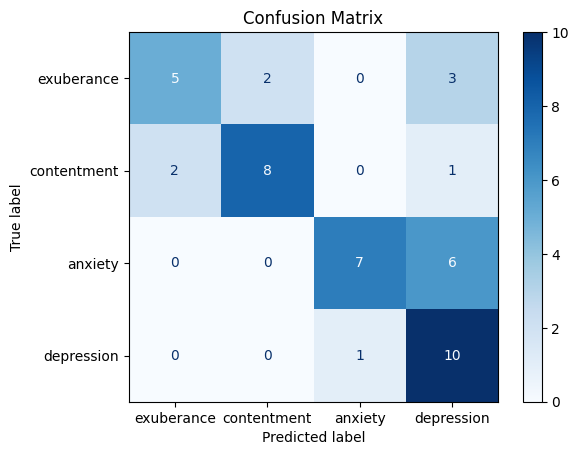

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, predicted_classes)

# Step 4: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['exuberance', 'contentment', 'anxiety', 'depression'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()